In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from text_model import TextModel, get_loss_function

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHOR = 'Oscar Wilde'

VAL_PARTITION = 0.3 
SENTENCE_LENGTH = 16
BATCH_SIZE = 8

In [4]:
# Try loading dataset, if it doesn't exists then creates it
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'))    
    print('Checkpoint loaded')
except:
    books = load_books(DATASET_FILENAME, author=AUTHOR)
    vocab, train_dataset, test_dataset = build_text_state(books, SENTENCE_LENGTH, VAL_PARTITION, vocab_name=AUTHOR)  
    print('No checkpoint found. New partition.')
    print('Included books:')
    for book in books:
        print('\t', book)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

No checkpoint found. New partition.
Included books:
	 Name: The Canterville ghost   Author: Oscar Wilde
	 Name: The picture of Dorian Gray   Author: Oscar Wilde


In [5]:
save_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'), vocab, train_dataset, test_dataset) 

### Loading components

In [6]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.1
BETA_2 = 0.999
EPOCHS = 50
NUM_HEADS = 8
ENCODER_LAYERS = 1
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.1
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.5

In [7]:
model = TextModel(
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)

optimizer = torch.optim.Adam(
    list(model.parameters()), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)

loss_fn = get_loss_function()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [8]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [9]:
def train_step(transformer, loss_fn, optimizer, batch):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(batch[:,1:], batch[:,:-1])
    
    loss = loss_fn(batch[:,1:], decodings)
    loss.backward()
    optimizer.step()
    return loss.item()    

In [10]:
def val_step(transformer, loss_fn, batch):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(batch[:,1:], batch[:,:-1])
        loss = loss_fn(batch[:,1:], decodings)

        return loss.item(), decodings

In [11]:
# Define steps where examples will be sampled 
test_examples = iter(test_dataloader)

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train dataset
    examples = iter(train_dataloader)

    # Progress bar for training dataset
    progress_bar = tqdm(range(len(train_dataloader)))
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:

        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        example = next(examples).to(device)
        train_loss += train_step(model, loss_fn, optimizer, example)


        if batch_idx == 0:
            try:
                example = next(test_examples).to(device)
            except:
                test_examples = iter(test_dataloader)
                example = next(test_examples).to(device)

            with torch.no_grad():
                _, decodings = val_step(model, loss_fn, example)
                decodings = torch.argmax(decodings[0], dim=-1).cpu().numpy()

            print('\nReal: {}'.format(vocab.to_words(example[0][1:].cpu().numpy())))
            print('Decoded: {}'.format(vocab.to_words(decodings)))

    # Validation
    val_examples = iter(test_dataloader)
    progress_bar = tqdm(range(len(test_dataloader)))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
        
        example = next(val_examples).to(device)
        
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, example)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / len(train_dataloader))
    val_loss_history.append(val_loss / len(test_dataloader))
    
    # If this model is best than other
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************



Real: ['and', 'you', 'have', 'sat', '<unk>', 'to', 'day', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['hinted', 'consisted', 'reason', 'consisted', 'hinted', 'cloud', 'cloud', 'hinted', 'consisted', 'consisted', 'consisted', 'consisted', 'consisted', 'consisted', 'consisted', 'consisted', 'consisted']




*************************** EPOCH 2 ***************************



Real: ['it', 'is', 'your', 'best', 'work', ',', 'basil', ',', 'the', 'best', 'thing', 'you', 'have', 'ever', 'done', ',', '<eos>']
Decoded: ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 3 ***************************



Real: ['some', '<unk>', 'it', 'was', 'a', 'dull', 'almost', '<unk>', 'red', ',', 'then', 'it', 'would', 'be', '<unk>', ',', '<eos>']
Decoded: ['i', 'there', 'there', 'a', 'they', 'there', 'a', 'i', 'there', 'there', 'she', 'there', 'and', 'i', 'there', 'dorian', '<eos>']




*************************** EPOCH 4 ***************************



Real: ['we', 'must', 'be', 'there', 'before', 'the', 'curtain', 'rises', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['we', 'must', 'be', 'there', 'would', 'the', 'been', 'gray', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 5 ***************************



Real: ['anything', 'that', 'would', 'tell', 'his', 'name', '?', 'some', 'money', ',', 'sir', 'not', 'much', ',', 'and', 'a', '<eos>']
Decoded: ['they', 'that', 'would', 'tell', 'his', 'name', '?', 'some', 'found', ',', 'sir', 'not', 'much', ',', 'and', 'a', '<eos>']




*************************** EPOCH 6 ***************************



Real: ['well', ',', 'sir', ',', 'you', "'", 'll', 'be', 'covered', 'with', '<unk>', 'if', 'you', 'go', 'into', 'it', '<eos>']
Decoded: ['well', ',', 'sir', ',', 'you', "'", 't', 'be', 'heard', 'with', 'ever', 'if', 'you', 'go', 'into', 'it', '<eos>']




*************************** EPOCH 7 ***************************



Real: ['he', 'was', 'conscious', 'and', 'the', 'thought', 'brought', 'a', '<unk>', 'of', 'pleasure', 'into', 'his', 'brown', '<unk>', 'eyes', '<eos>']
Decoded: ['he', 'was', 'conscious', 'and', 'the', 'thought', 'brought', 'a', 'large', 'of', 'pleasure', 'into', 'his', 'single', 'without', 'eyes', '<eos>']




*************************** EPOCH 8 ***************************



Real: ['the', 'joy', 'of', '<unk>', 'was', 'my', 'joy', ',', 'and', 'the', 'sorrows', 'of', '<unk>', 'were', 'mine', 'also', '<eos>']
Decoded: ['the', 'joy', 'of', 'caught', 'was', 'my', 'joy', ',', 'and', 'the', 'opera', 'of', 'caught', 'were', 'london', 'room', '<eos>']




*************************** EPOCH 9 ***************************



Real: ['<unk>', 'is', 'a', 'fatal', 'thing', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['everybody', 'is', 'a', 'fatal', 'thing', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 10 ***************************



Real: ['must', 'i', 'really', 'come', ',', 'harry', '?', 'certainly', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['must', 'i', 'really', 'come', ',', 'harry', '?', 'certainly', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 11 ***************************



Real: ['how', 'exquisite', 'life', 'had', 'once', 'been', '!', 'how', 'gorgeous', 'in', 'its', '<unk>', 'and', '<unk>', '!', 'even', '<eos>']
Decoded: ['how', 'exquisite', 'life', 'had', 'once', 'been', '!', 'how', 'servants', 'in', 'its', 'curiosity', 'and', 'along', '!', 'even', '<eos>']




*************************** EPOCH 12 ***************************



Real: ['if', 'you', 'ask', 'them', 'their', 'opinion', 'on', 'something', 'that', 'happened', 'yesterday', ',', 'they', 'solemnly', 'give', 'you', '<eos>']
Decoded: ['if', 'you', 'ask', 'them', 'their', 'opinion', 'on', 'something', 'that', 'happened', 'yesterday', ',', 'they', 'burned', 'give', 'you', '<eos>']




*************************** EPOCH 13 ***************************



Real: ['i', 'don', "'", 't', 'know', ',', 'answered', 'lord', 'henry', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['i', 'don', "'", 't', 'know', ',', 'answered', 'lord', 'henry', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 14 ***************************



Real: ['the', '<unk>', 'became', 'unbearable', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'pit', 'became', 'stopped', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 15 ***************************



Real: ['the', 'girl', 'smiled', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'girl', 'smiled', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 16 ***************************



Real: ['it', "'", 's', 'a', '<unk>', 'bores', 'have', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['it', "'", 's', 'a', 'curiosity', 'hide', 'have', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 17 ***************************



Real: ['what', 'an', '<unk>', 'the', 'man', 'was', 'to', 'get', 'in', 'front', 'of', 'the', '<unk>', '!', 'stop', 'shooting', '<eos>']
Decoded: ['what', 'an', 'curiosity', 'the', 'man', 'was', 'to', 'get', 'in', 'front', 'of', 'the', 'curiosity', '!', 'stop', 'shooting', '<eos>']




*************************** EPOCH 18 ***************************



Real: ['your', 'mysterious', 'young', 'friend', ',', 'whose', 'name', 'you', 'have', 'never', 'told', 'me', ',', 'but', 'whose', 'picture', '<eos>']
Decoded: ['your', 'mysterious', 'young', 'friend', ',', 'whose', 'name', 'you', 'have', 'never', 'told', 'me', ',', 'but', 'whose', 'picture', '<eos>']




*************************** EPOCH 19 ***************************



Real: ['i', 'am', 'too', 'shabby', ',', 'he', 'answered', ',', 'frowning', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['i', 'am', 'too', 'shabby', ',', 'he', 'answered', ',', 'ultimately', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 20 ***************************



Real: ['he', 'was', 'afraid', 'of', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['he', 'was', 'afraid', 'of', 'curiosity', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 21 ***************************



Real: ['he', 'looked', 'down', ',', 'and', 'saw', 'the', 'policeman', 'going', 'his', '<unk>', 'and', 'flashing', 'the', 'long', '<unk>', '<eos>']
Decoded: ['he', 'looked', 'down', ',', 'and', 'saw', 'the', 'policeman', 'going', 'his', 'rheims', 'and', 'democritus', 'the', 'long', 'rheims', '<eos>']




*************************** EPOCH 22 ***************************



Real: ['yet', 'it', 'had', 'to', 'be', 'done', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['yet', 'it', 'had', 'to', 'be', 'done', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 23 ***************************



Real: ['my', 'dear', 'boy', ',', 'said', 'lord', 'henry', ',', 'smiling', ',', 'anybody', 'can', 'be', 'good', 'in', 'the', '<eos>']
Decoded: ['my', 'dear', 'boy', ',', 'said', 'lord', 'henry', ',', 'smiling', ',', 'anybody', 'can', 'be', 'good', 'in', 'the', '<eos>']




*************************** EPOCH 24 ***************************



Real: ['a', 'woman', 'in', 'a', '<unk>', '<unk>', 'was', 'creeping', 'slowly', 'by', 'the', '<unk>', ',', '<unk>', 'as', 'she', '<eos>']
Decoded: ['a', 'woman', 'in', 'a', 'martyr', 'borrowed', 'was', 'creeping', 'slowly', 'by', 'the', 'martyr', ',', 'ultimately', 'as', 'she', '<eos>']




*************************** EPOCH 25 ***************************



Real: ['some', '<unk>', 'wind', 'of', 'passion', 'swept', 'over', 'her', ',', 'and', 'stirred', 'the', 'dainty', '<unk>', 'of', 'her', '<eos>']
Decoded: ['some', 'curiosity', 'wind', 'of', 'passion', 'swept', 'over', 'her', ',', 'and', 'stirred', 'the', 'dainty', 'transaction', 'of', 'her', '<eos>']




*************************** EPOCH 26 ***************************



Real: ['paradoxes', 'are', 'all', 'very', 'well', 'in', 'their', 'way', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['paradoxes', 'are', 'all', 'very', 'well', 'in', 'their', 'way', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 27 ***************************



Real: ['we', 'live', 'in', 'an', 'age', 'when', 'men', 'treat', 'art', 'as', 'if', 'it', 'were', 'meant', 'to', 'be', '<eos>']
Decoded: ['we', 'live', 'in', 'an', 'age', 'when', 'men', 'treat', 'art', 'as', 'if', 'it', 'were', 'meant', 'to', 'be', '<eos>']




*************************** EPOCH 28 ***************************



Real: ['come', ',', 'don', "'", 't', 'work', 'yourself', 'into', 'this', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['come', ',', 'don', "'", 't', 'work', 'yourself', 'into', 'this', 'curiosity', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 29 ***************************



Real: ['it', 'seemed', 'to', 'crush', 'him', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['it', 'seemed', 'to', 'rechristening', 'him', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 30 ***************************



Real: ['why', 'did', 'he', 'get', 'in', 'front', 'of', 'the', '<unk>', '?', 'besides', ',', 'it', "'", 's', 'nothing', '<eos>']
Decoded: ['why', 'did', 'he', 'get', 'in', 'front', 'of', 'the', 'martyr', '?', 'besides', ',', 'it', "'", 's', 'nothing', '<eos>']




*************************** EPOCH 31 ***************************



Real: ['i', 'see', 'that', 'basil', 'is', 'in', 'one', 'of', 'his', 'sulky', 'moods', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['i', 'see', 'that', 'basil', 'is', 'in', 'one', 'of', 'his', 'gorgeous', 'moods', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 32 ***************************



Real: ['crime', 'belongs', '<unk>', 'to', 'the', '<unk>', 'orders', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['crime', 'belongs', 'curiosity', 'to', 'the', 'martyr', 'orders', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 33 ***************************



Real: ['i', 'suppose', 'in', 'about', 'a', 'fortnight', 'we', 'shall', 'be', 'told', 'that', 'he', 'has', 'been', 'seen', 'in', '<eos>']
Decoded: ['i', 'suppose', 'in', 'about', 'a', 'quarrelling', 'we', 'shall', 'be', 'told', 'that', 'he', 'has', 'been', 'seen', 'in', '<eos>']




*************************** EPOCH 34 ***************************



Real: ['that', 'awful', 'memory', 'of', 'woman', '!', 'what', 'a', 'fearful', 'thing', 'it', 'is', '!', 'and', 'what', 'an', '<eos>']
Decoded: ['that', 'shrank', 'memory', 'of', 'woman', '!', 'what', 'a', 'fearful', 'thing', 'it', 'is', '!', 'and', 'what', 'an', '<eos>']




*************************** EPOCH 35 ***************************



Real: ['don', "'", 't', 'keep', 'dorian', 'too', 'long', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['don', "'", 't', 'keep', 'dorian', 'too', 'long', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 36 ***************************



Real: ['the', 'portrait', 'must', 'be', 'hidden', 'away', 'at', 'all', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'portrait', 'must', 'be', 'hidden', 'away', 'at', 'all', 'borrowed', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 37 ***************************



Real: ['she', 'told', 'me', 'she', 'had', 'discovered', 'a', 'wonderful', 'young', 'man', ',', 'who', 'was', 'going', 'to', 'help', '<eos>']
Decoded: ['she', 'told', 'me', 'she', 'had', 'discovered', 'a', 'wonderful', 'young', 'man', ',', 'who', 'was', 'going', 'to', 'help', '<eos>']




*************************** EPOCH 38 ***************************



Real: ['but', 'the', 'world', 'might', 'guess', 'it', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['but', 'the', 'world', 'might', 'associate', 'it', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 39 ***************************



Real: ['he', 'felt', 'that', 'dorian', 'gray', 'would', 'never', 'again', 'be', 'to', 'him', 'all', 'that', 'he', 'had', 'been', '<eos>']
Decoded: ['he', 'felt', 'that', 'dorian', 'gray', 'would', 'never', 'again', 'be', 'to', 'him', 'all', 'that', 'he', 'had', 'been', '<eos>']




*************************** EPOCH 40 ***************************



Real: ['a', 'faint', 'echo', 'of', 'his', 'love', 'came', 'back', 'to', 'him', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['a', 'faint', 'echo', 'of', 'his', 'love', 'came', 'back', 'to', 'him', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 41 ***************************



Real: ['it', 'was', 'the', 'imagination', 'that', 'set', 'remorse', 'to', 'dog', 'the', 'feet', 'of', 'sin', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['it', 'was', 'the', 'imagination', 'that', 'set', 'remorse', 'to', 'dog', 'the', 'feet', 'of', 'sin', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 42 ***************************



Real: ['next', 'to', 'her', 'sat', ',', 'on', 'her', 'right', ',', 'sir', 'thomas', '<unk>', ',', 'a', 'radical', 'member', '<eos>']
Decoded: ['next', 'to', 'her', 'sat', ',', 'on', 'her', 'right', ',', 'sir', 'thomas', 'borrowed', ',', 'a', 'radical', 'member', '<eos>']




*************************** EPOCH 43 ***************************



Real: ['i', 'like', 'it', 'better', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['i', 'like', 'it', 'better', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 44 ***************************



Real: ['he', 'could', 'see', 'no', 'change', ',', 'save', 'that', 'in', 'the', 'eyes', 'there', 'was', 'a', 'look', 'of', '<eos>']
Decoded: ['he', 'could', 'see', 'no', 'change', ',', 'prepared', 'that', 'in', 'the', 'eyes', 'there', 'was', 'a', 'look', 'of', '<eos>']




*************************** EPOCH 45 ***************************



Real: ['go', 'back', '!', 'little', 'virginia', ',', 'they', 'cried', ',', 'go', 'back', '!', 'but', 'the', 'ghost', 'clutched', '<eos>']
Decoded: ['go', 'back', '!', 'little', 'virginia', ',', 'they', 'cried', ',', 'go', 'back', '!', 'but', 'the', 'ghost', 'ladies', '<eos>']




*************************** EPOCH 46 ***************************



Real: ['his', '<unk>', 'intellectual', 'passion', 'was', 'for', 'science', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['his', 'martyr', 'intellectual', 'passion', 'was', 'for', 'yelling', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 47 ***************************



Real: ['the', 'past', 'could', 'always', 'be', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'past', 'could', 'always', 'be', 'vaguely', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 48 ***************************



Real: ['only', 'in', 'public', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['only', 'in', 'public', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 49 ***************************



Real: ['ah', '!', 'lord', 'henry', ',', 'i', 'wish', 'you', 'would', 'tell', 'me', 'how', 'to', 'become', 'young', 'again', '<eos>']
Decoded: ['ah', '!', 'lord', 'henry', ',', 'i', 'wish', 'you', 'would', 'tell', 'me', 'how', 'to', 'become', 'young', 'again', '<eos>']



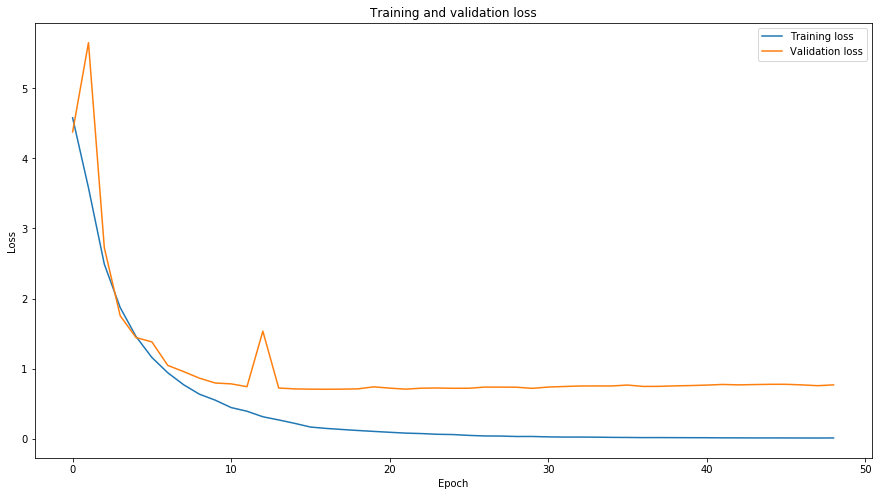

In [12]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [13]:
argmin_val = np.argmin(val_loss_history)
print('Lower validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val))

Lower validation loss: 0.7066022956099075 in epoch 16
